<a href="https://colab.research.google.com/github/vinhthanh11/Portfolio-Value-at-Risk/blob/main/Portfolio_VaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install datetime
!pip install matplotlib
!pip install pandas_datareader
!pip install yfinance
!pip install pandas-profiling
!pip install cast_control==0.10.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.6/381.6 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.7 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27082 sha256=4088eff702e393f566e7e75a4f44c8146158ce7207ec99ea989d19

# Portfolio Value-at-Risk (VaR) estimation and evaluation

### Introduction

* Value at Risk (VAR) is a rather simple yet valuable risk estimation measure, which helps traders and investors understand the risk of loss for their investments. Using VaR financial professionals can estimate how much their investments could lose in a specified time window (e.g., during a day or month) under normal market conditions.

* VaR can be calculated at different levels and granularities. For example, it can used to estimate the risk of a single asset or of a portfolio of assets. This is a very common use of VaR by commercial banks and investment organizations, which wish to estimate and understand the potential losses of their institutional portfolios.

* From a statistical perspective VaR quantifies the maximum potential losses over a specified timeframe with a degree of confidence. Confidence is therefore an important parameter of VaR calculation. For example, if for a given portfolio the 95% confidence of a one-day VAR is 100.000 EUR, this means that there is a 95% confidence that the portfolio will not lose more than 100.000 EUR within a day. 95% and 99% are the most common confidence internals used in VaR calculation.

$$P[r < VaR_a] = a $$ where r, a are the portfolio returns and the confidence probability respectively.

* Since the introduction of VaR as a standard risk metric, various types of models have been developed for its assessment. The main categories of which are the:
    * Non-Parametric: Assumptions regarding the distribution of returns are not required. The Historical Simulation (HS) is the main representative of this method, where the empirical distribution of past portfolio returns is used to calculate VaR.
    * Parametric: Portfolio returns and their distribution should be theoretically defined prior to VaR estimation. Some well-known methods of the parametric category are the Variance-Covariance Method (VC) and many GARCH-variants Methods, such as the Risk Metrics model.

    * Semi-Parametric: Some assumptions regarding the distribution of returns are made. The Monte Carlo Method is the main semi-parametric method which generates random scenarios for future portfolio returns, drawing their distribution based on some non-linear pricing models.

### Exploratory Data Analysis

In [5]:
# import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas_datareader as pdr
import yfinance as yf

# set plotting parameters
%matplotlib inline
sns.set_style("whitegrid")
plt.rc("figure", figsize=(16, 8))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)


#### The Data

* We download historical market data from yahoo finance for Apple, Google, Facebook, Nvidia and Tesla stocks. The dataset consists of daily market data such as open, high, low and close prices ranging from 2016-01-01 to 2021-12-31.

In [6]:
# load historical data from yahoo finance
tickers = ['aapl', 'goog', 'meta', 'nvda', 'tsla']
data = yf.download(tickers, start='2016-01-01', end='2021-12-31')


[*********************100%%**********************]  5 of 5 completed


* For this analysis we will use only the adjusted close prices. The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

* The below plot of daily prices is misleading in understanding the performance of each stock because Google market price is traded at a much higher rate than the other stocks.

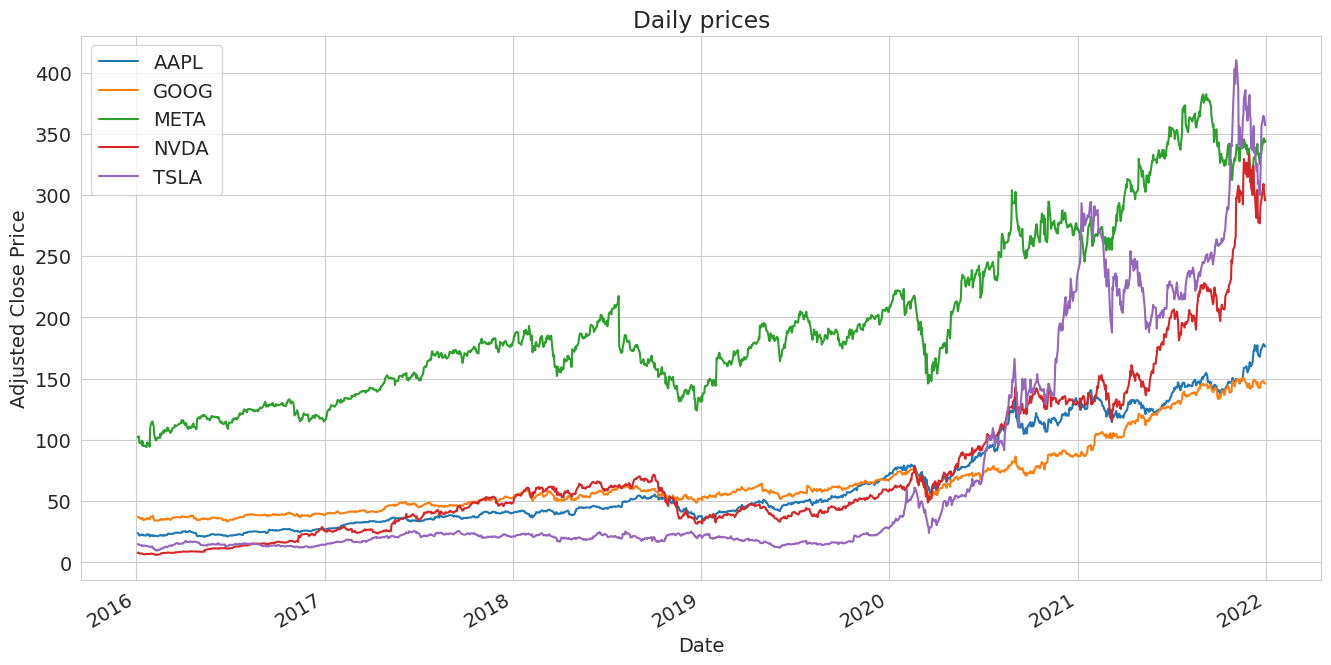

In [7]:
prices = data['Adj Close']
prices.plot()
plt.title('Daily prices')
plt.ylabel('Adjusted Close Price')
plt.show()

* To alleviate this issue we rescale our data to log prices. The log prices plot illustrates that Google and Facebook stocks had similar performance, while Nvidia and Tesla had higher growth than the others.

* However, in order to be able to perform forecasting and reliable analysis in timeseries data these data should be stationary.

* A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary. Here, we can observe that all the time series have an up trend.

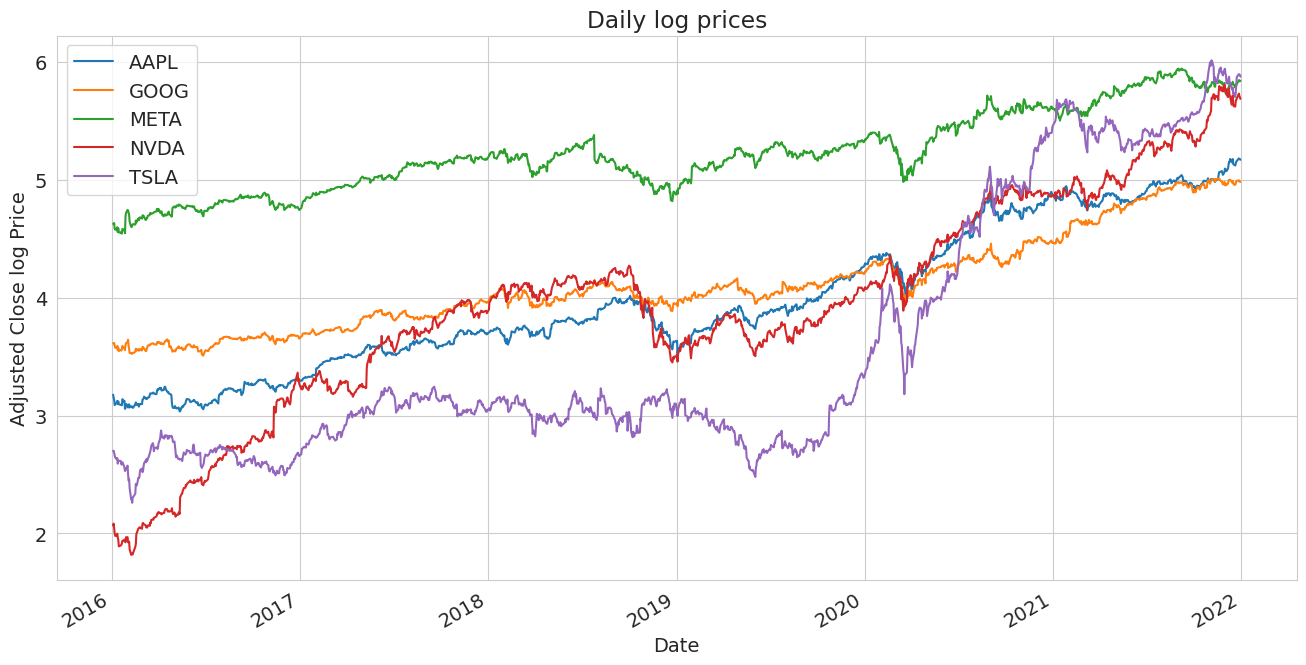

In [8]:
np.log(prices).plot()
plt.ylabel('Adjusted Close log Price')
plt.title('Daily log prices')
plt.show()

* The most common technique for making a time series stationary or at least close to stationary is to use its rate of change from the one time step to the next.

* So instead of analyzing the prices $p$, we will transform them in terms of daily returns $r$ based on the following formula.

$$r_t = \frac{p_t-p_{t-1}}{p_{t-1}}$$


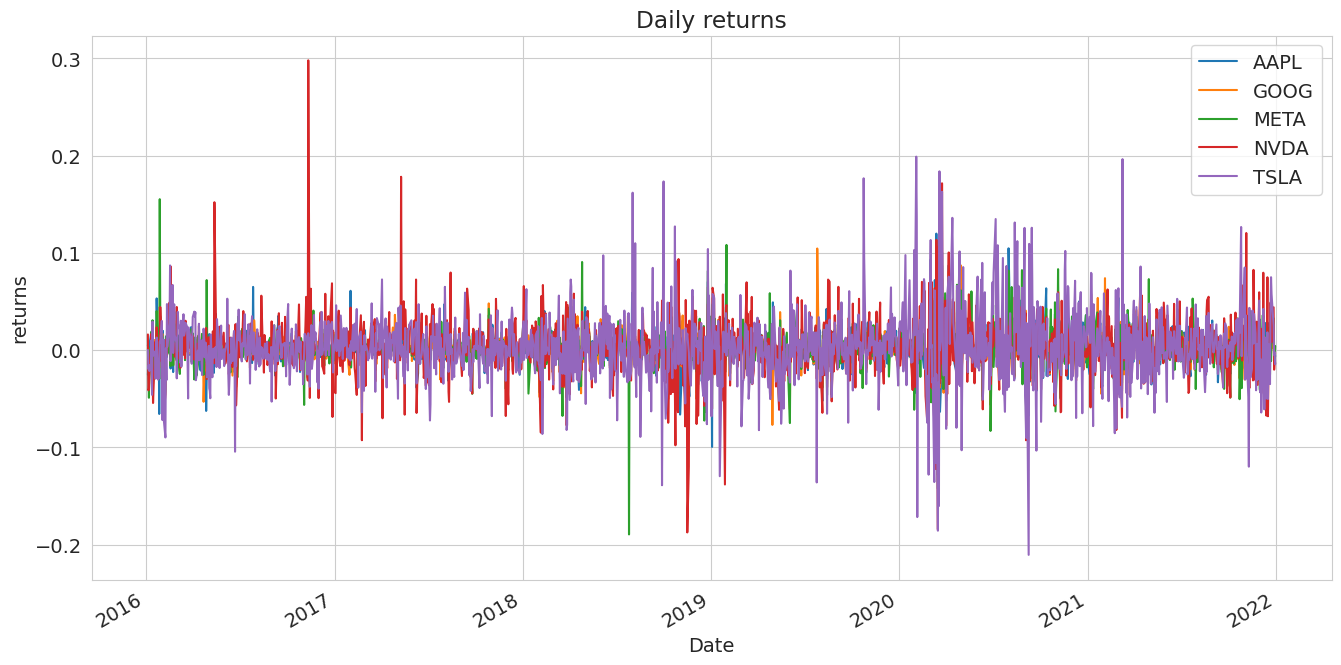

In [9]:
returns = data['Adj Close'].pct_change()
# returns = returns.dropna(axis=1, how='all')
returns.plot()
plt.title('Daily returns')
plt.ylabel('returns')
plt.show()

* As we can see from the above graph of returns, after the transformation the upward trend in the time series was eliminated and now they are moving around zero. This means that time series are now closer to stationarity and we can use them for our analysis.

* Note that the time series are still not stationary as they  have not constant variance over time, however, time series stationarity goes beyond the scope of this notebook. For more information on time series stability, see this article: https://machinelearningmastery.com/time-series-data-stationary-python/

In [10]:
returns_summary = (returns*100).describe()
returns_summary.round(2)[1:]


,AAPL,GOOG,META,NVDA,TSLA
mean,0.15,0.10,0.10,0.28,0.28
std,1.85,1.63,2.04,2.97,3.61
min,-12.86,-11.10,-18.96,-18.76,-21.06
25%,-0.63,-0.57,-0.78,-1.09,-1.45
50%,0.11,0.13,0.11,0.27,0.15
75%,1.03,0.89,1.13,1.72,1.93
max,11.98,10.45,15.52,29.81,19.89


* Uncomment the bellow cell of code for more EDA

In [11]:
from pandas_profiling import ProfileReport

profile = ProfileReport(returns, minimal=True)
profile


PydanticImportError: ignored

### Historical Simulation (HS) VaR

* The Historical Simulation (HS) is the main representative of the non-parametric VaR method, where the empirical distribution of past portfolio returns is used to calculate VaR.

* This is probably the simplest VaR calculation method. It relies on significant volumes of historical market data (e.g., typically one trading year data for conventional assets and much more than that for hedge funds) to calculate the price changes for all the assets of the portfolio. Accordingly, it calculates the value of the portfolio for each one of the price changes. These historical values for the portfolio can be sorted and used to form a distribution. Then the VaR at a given confidence level (e.g., 99%) is computed from the respective quantile of the formed (e.g., 1% lowest value for the 99% case) in the series of simulated portfolio values.


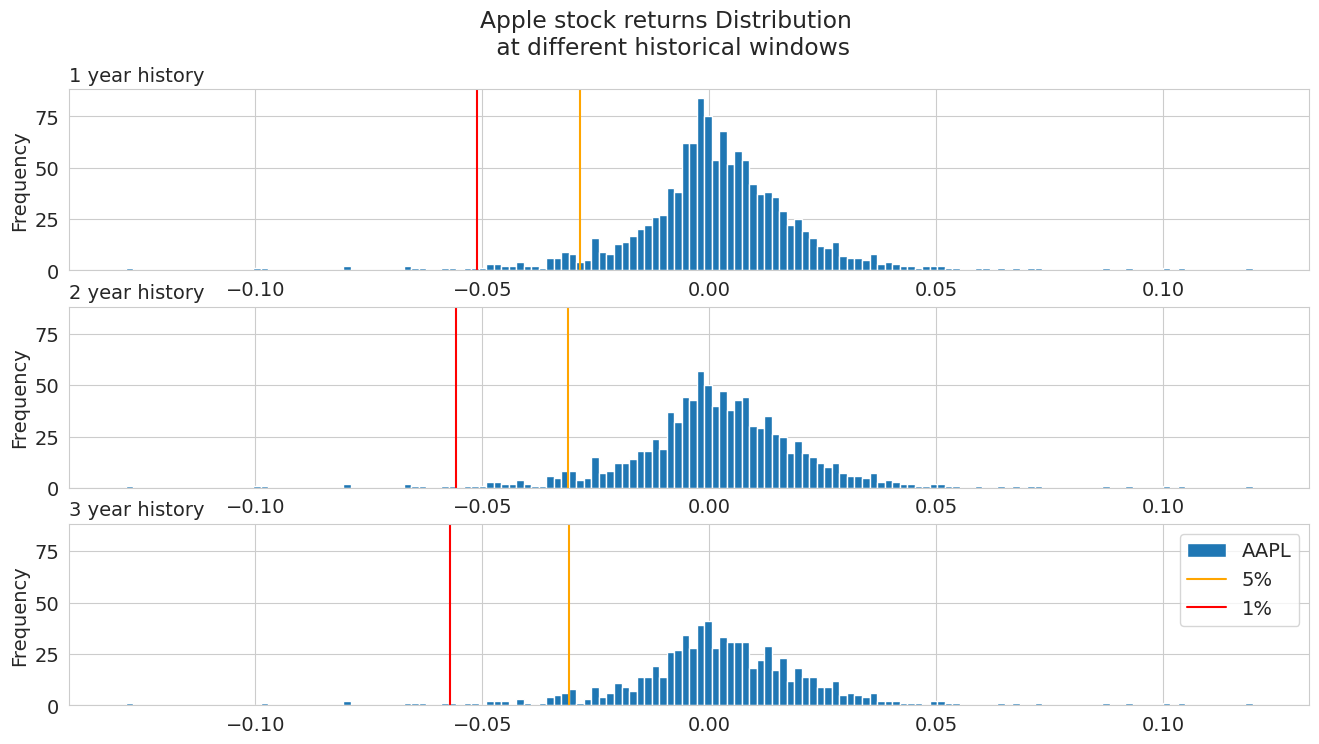

In [12]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharey=True, )
fig.suptitle('Apple stock returns Distribution \n at different historical windows')

history1 = returns['AAPL'][253:]
ax1 = history1.plot(kind='hist', bins=150, ax=ax1)
ax1.axvline(np.percentile(history1, 5), color='orange', label='5%')
ax1.axvline(np.percentile(history1, 1), color='red', label='1%')
ax1.set_title('1 year history', loc='left', fontsize=14)

history2 = returns['AAPL'][2*253:]
ax2 = history2.plot(kind='hist', bins=150, ax=ax2)
ax2.axvline(np.percentile(history2, 5), color='orange', label='5%')
ax2.axvline(np.percentile(history2, 1), color='red', label='1%')
ax2.set_title('2 year history', loc='left', fontsize=14)

history3 = returns['AAPL'][3*253:]
ax3 = history3.plot(kind='hist', bins=150, ax=ax3)
ax3.axvline(np.percentile(history3, 5), color='orange', label='5%')
ax3.axvline(np.percentile(history3, 1), color='red', label='1%')
ax3.set_title('3 year history', loc='left', fontsize=14)
plt.legend()
plt.show()

In [13]:
print(returns)

                AAPL      GOOG      META      NVDA      TSLA
Date                                                        
2016-01-04       NaN       NaN       NaN       NaN       NaN
2016-01-05 -0.025059  0.000998  0.004989  0.016064  0.000090
2016-01-06 -0.019570  0.001400  0.002336 -0.041350 -0.019648
2016-01-07 -0.042205 -0.023170 -0.049043 -0.039645 -0.015477
2016-01-08  0.005287 -0.016410 -0.006025 -0.021466 -0.021563
...              ...       ...       ...       ...       ...
2021-12-23  0.003644  0.001317  0.014495  0.008163  0.057619
2021-12-27  0.022975  0.006263  0.032633  0.044028  0.025248
2021-12-28 -0.005767 -0.010914  0.000116 -0.020132 -0.005000
2021-12-29  0.000502  0.000386 -0.009474 -0.010586 -0.002095
2021-12-30 -0.006578 -0.003427  0.004141 -0.013833 -0.014592

[1510 rows x 5 columns]


In [14]:
def hs(returns, alpha=95, time_frame='day'):
    '''Calculates Historical VaR for daily data

    Parameters
    ----------
    returns : array_like with dims [TxN] where N the number of the assets forming the portfolio
        and T the number of the historical data.
        Input array or object that can be converted to an array.
        It is assumed that the values have daily frequency.
    alpha : {float}, optional, default=95
        Probability of occurrence for the amount of loss to compute, which must be between
        0 and 100 inclusive.
    time_frame : {str}, optional, default='day'
        The timeframe of the VaR estimation in days. The default calculates daily VaR.
        Input Options: {'day', 'month', 'quarter', 'year'}
     For the monthly VaR the daily VaR is multiplied by the square root of 21,
     for the quarterly VaR by 63 and for the annual VaR by 253.

    Returns
    -------
    historical VaR in returns terms: scalar or ndarray
        If returns is a single time-series, then the result
        is a scalar. If multiple time-series are given, the result is a vector
        with same length as number of the input series.
    '''
    if time_frame == 'day':
        time = 1
    elif time_frame == 'month':
        time = 21
    elif time_frame == 'quarter':
        time = 63
    elif time_frame == 'year':
        time = 253
    else:
        raise ValueError("'time_frame' input value must be one of {'day', 'month', 'quarter', 'year'}")

    q = 100 - alpha
    var = -np.sqrt(time) * np.percentile(returns, q, axis=0, method='inverted_cdf')
    return np.round(var, 4)

* Example: 95% Historical VaR of €1000 imvestment in each stock.

In [37]:
# clear NaN
returns = returns.dropna()
# input params
investment = 1000
prob = 85
# Portfolio VaR calculation for different time horizons
varD = investment * hs(returns, alpha=prob, time_frame='day')
varM = investment * hs(returns, alpha=prob, time_frame='month')
varQ = investment * hs(returns, alpha=prob, time_frame='quarter')
varY = investment * hs(returns, alpha=prob, time_frame='year')
# put results in dataframe
res = np.concatenate((varD.reshape(1, len(varD)),
                varM.reshape(1, len(varM)),
                varQ.reshape(1, len(varQ)),
                varY.reshape(1, len(varY))), axis=0)
var = pd.DataFrame(res, columns=tickers)
var['HS VaR (€)'] = ['Daily', 'Monthly', 'Quarterly', 'Annual']
cols = tickers.copy()
cols.insert(0, "HS VaR (€)")
var = var[cols]
var

,HS VaR (€),aapl,goog,meta,nvda,tsla
0,Daily,12.2,11.5,14.3,20.2,25.7
1,Monthly,55.9,52.8,65.4,92.4,117.7
2,Quarterly,96.8,91.5,113.2,160.0,203.9
3,Annual,194.0,183.3,226.8,320.7,408.6


### Portfolio VaR

To compute the VaR of a portfolio, the correlation $\rho$ among the financial instruments should be taken into account. In this case, the VaR of a portfolio for a given day can be estimated by the following Equation:
\begin{equation} \label{VaR_p}
    VaR^{\alpha}_p = \sqrt{VRV^T}     
\end{equation}

where $V$ is a vector of the weighted VaR estimates per instrument $V = [w_{aapl}VaR^{\alpha}_{apple}, w_{goog}VaR^{\alpha}_{goog}, \dots, w_{tsla}VaR^{\alpha}_{tsla}]$ and $R$ is the correlation matrix of stocks'   daily returns.


In [38]:
def portfolio_var(returns, w, alpha=95, time_frame='day'):
    '''Calculate Historical VaR for daily data

    Parameters
    ----------
    returns : array_like with dims [TxN] where N the number of the assets forming the portfolio
        and T the number of the historical data.
        Input array or object that can be converted to an array.
        It is assumed that the values have daily frequency.
    w: list or 1D numpy array with dims [1xN]
        The weight of each asset/timeseries.
        The values of w must be floats between 0 and 1 with their sum equal to 1.


    alpha : {float}, optional, default=95
        Probability of occurrence for the amount of loss to compute, which must be between
        0 and 100 inclusive.
    time_frame : {str}, optional, default='day'
        The timeframe of the VaR estimation in days. The default calculates daily VaR.
        Input Options: {'day', 'month', 'quarter', 'year'}
     For the monthly VaR the daily VaR is multiplied by the square root of 21,
     for the quarterly VaR by 63 and for the annual VaR by 253.

    Returns
    -------
    Portfolio historical VaR in returns terms: scalar
    '''

    w = np.array(w)
    if w.sum() != 1:
        raise ValueError('The sum of w must be equal to 1')
    w = w.reshape(1, returns.shape[1])
    # calculate weighted VaR for each asset forming the portfolio, dims [1xN]
    V = w * hs(returns, alpha=alpha, time_frame=time_frame)
    # calculate correlation matrix with dims [NxN]
    R = returns.corr()
    # calculate portfolio VaR
    var = np.sqrt(V @ R @ V.T)[0][0]
    return np.round(var, 4)

* Example: 95% Historical VaR of €1000 investment in a balanced portfolio.

In [39]:
#input params
investment = 1000
prob = 95
weights = np.array([.2, .2, .2, .2, .2])
# Portfolio VaR calculation for different time horizons
varD = investment * portfolio_var(returns, w=weights, alpha=prob, time_frame='day')
varM = investment * portfolio_var(returns, w=weights, alpha=prob, time_frame='month')
varQ = investment * portfolio_var(returns, w=weights, alpha=prob, time_frame='quarter')
varY = investment * portfolio_var(returns, w=weights, alpha=prob, time_frame='year')
# put results in dataframe
res = np.array([[varD], [varM],[varQ],[varY]])
var['portfolio'] = res
var

,HS VaR (€),aapl,goog,meta,nvda,tsla,portfolio
0,Daily,12.2,11.5,14.3,20.2,25.7,26.3
1,Monthly,55.9,52.8,65.4,92.4,117.7,120.7
2,Quarterly,96.8,91.5,113.2,160.0,203.9,209.0
3,Annual,194.0,183.3,226.8,320.7,408.6,418.8


### Portfolio VaR evaluation

![title](https://github.com/giorgosfatouros/Portfolio-Value-at-Risk-estimation/blob/main/var_evaluation.png?raw=1)

In [41]:
test_day = '2017-01-02'
# select train set according to the selected history window
train = returns[returns.index < test_day]
test = returns[returns.index >= test_day]

# list to save results
hs95 = []
hs99 = []
for day in test.index:
    # calculate VaR for 95% and 99% Confidence
    hs95.append(portfolio_var(train, w=weights, alpha=95, time_frame='day'))
    hs99.append(portfolio_var(train, w=weights, alpha=99, time_frame='day'))
    # move training window
train = pd.concat([train, test[test.index == day]]).iloc[1:]

# true portfolio returns for the testing period
pnl = (weights * test).sum(axis=1).values
# save results to pandas df
df = pd.DataFrame({"HS95":hs95,"HS99":hs99, "PnL":pnl}, index=test.index)

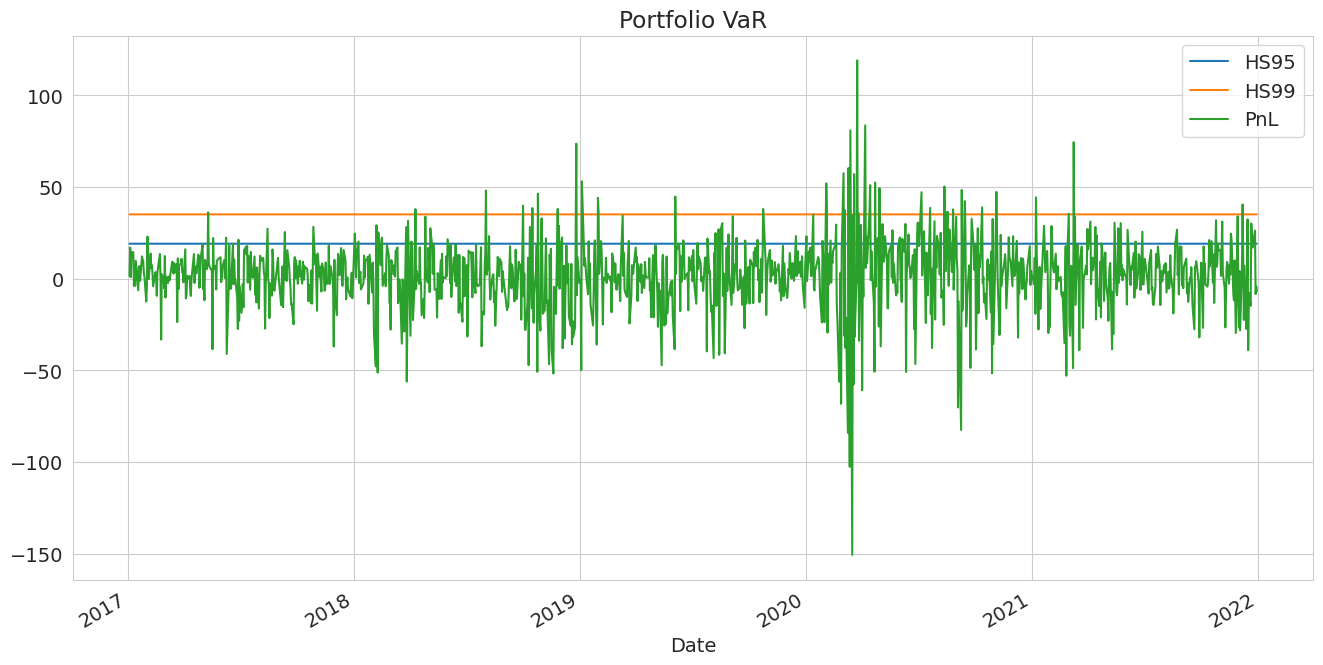

In [42]:
(investment * df).plot()
plt.title('Portfolio VaR')
plt.show()

In [34]:
class Backtest:
    def __init__(self, actual, forecast, alpha):
        self.index = actual.index
        self.actual = actual.values
        self.forecast = forecast.values
        self.alpha = (100-alpha)/100

    def hit_series(self):
        return (self.actual < self.forecast) * 1

    def number_of_hits(self):
        return self.hit_series().sum()

    def hit_rate(self):
        return np.round(self.hit_series().mean() * 100, 2)

    def expected_hits(self):
        return self.actual.size * self.alpha

In [35]:
bt95 = Backtest(df.PnL, df.HS95, 95)
bt99 = Backtest(df.PnL, df.HS99, 99)
data = [[bt95.expected_hits(), bt95.number_of_hits(), bt95.hit_rate()],
        [bt99.expected_hits(), bt99.number_of_hits(), bt99.hit_rate()]]
cols = ['Expected violations', 'Violations number', 'Violation rate(%)']
idx = ['HS95', 'HS99' ]
pd.DataFrame(data, columns=cols, index=idx)

,Expected violations,Violations number,Violation rate(%)
HS95,62.90,1104,87.76
HS99,12.58,1218,96.82
